In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import emcee
import corner
import pickle
import models
import inspect

from IPython.display import display, Math
from pathlib import Path
from multiprocessing import Pool

from evolver import Evolver
from models import Model3
from util_funs import find_initial_params, plot_chains, print_latex_result, read_files,\
    filter_data, filter_file_names

np.random.seed(12345)

%load_ext autoreload
%autoreload 2

# True if you want to read from the dataset files, False if you want to generate the date with the model
USE_DATASET = True


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
if not USE_DATASET:
    # m0, w1, w2, u, v = 0.5, 0.7, 3, 0.1, 2
    # model = Model1_2(m0=m0, w1=w1, w2=w2, u=u, v=v)
    # model.summary(show_h=False)

    # m0, w1, w2, u, v = 0.5, 2, 3, 0.8, 20
    # model = Model1_2(m0=m0, w1=w1, w2=w2, u=u, v=v)
    # model.summary(show_h=False)

    # Here we define our model
    a, b, c, d, m_f_i, w2, u, v = 4, 0.3, 3, 10, 5, 0.8, 2, 7
    model = Model3(a=a, b=b, c=c, d=d, m_f=m_f_i, w2=w2, u=u, v=v)
    alpha = model.alpha
    k = model.k

    # Plot the model
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    model.get_figure(axs[0])


    # Here we make the model evolve (and divide)
    n_generations = 400
    evolver = Evolver(model=model)
    evolver.evolve(n_generations, debug=False)

    # Here we show some of the result
    end_gen = 30
    time, data = evolver.get_data(0, end_gen)
    final_time, final_data = evolver.get_start_data(0, end_gen)

    ptime = evolver.time[evolver.offset_start[0] : evolver.offset_end[end_gen] + 1]
    params = evolver.params[evolver.offset_start[0] : evolver.offset_end[end_gen] + 1]

    axs[1].plot(time, data[:, 0])
    axs[1].set_title('Microbe Size')
    axs[1].plot(final_time, final_data[:, 0], marker = 'o', linestyle = '');

In [14]:
# Here we use the data generated from our model to estimate the parameters 

if not USE_DATASET:
    truth = [a, b, c, d, w2, u, v] # our parameters defined above
    labels = ['a', 'b', 'c', 'd', 'w2', 'u', 'v']

    nwalkers = 25 # number of walkers for the MCMC
    # We add some gaussian noise to our initial parameters
    guess = np.array(truth) + 1e-4 * np.random.randn(nwalkers, len(truth)) 

    # This is still Model3 specific
    spans = evolver.spans
    alphas = evolver.get_alphas()[:-1]
    kappas = evolver.get_kappas()[:-1]
    m_finals = evolver.get_mfinals()[:-1]


    from multiprocessing import Pool
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, len(truth), evolver.model.log_prob,
                                        args=(spans, alphas, kappas, m_finals), pool=pool)
        sampler.run_mcmc(guess, 5000, progress=True)

    samples = sampler.get_chain()
    plot_chains(samples, title="TITOLO", labels=labels)

    tau = None
    try:
        tau = sampler.get_autocorr_time()
        print("Auto correlation time:", tau)
    except emcee.autocorr.AutocorrError as e:
        print("The chain is too short to get the auto correlation time")

    if tau is not None:
        thin_number = int(np.mean(tau) / 2)
        print(f"The thinning is {thin_number}, calculated from the auto correlation time")
    else:
        thin_number = 35
        print(f"The thinning is {thin_number}, the default value")

    flat_samples = sampler.get_chain(discard=500, thin=thin_number, flat=True)
    print("Flat samples shape: ", flat_samples.shape)

    fig = corner.corner(flat_samples, labels=labels, truths=truth)
    fig.suptitle(f"TITOLO")
    plt.show()

    result_dict = {}
    for i in range(len(labels)):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        result_dict[labels[i]] = (mcmc[1], q[0], q[1])
        
    print_latex_result(list(result_dict.values()), labels)


In [15]:
################### TO READ AND WRITE THE DATASET ###################

tanouchi25c_set = pd.read_csv("./dataset/Tanouchi25C.csv")
tanouchi37c_set = pd.read_csv("./dataset/Tanouchi37C.csv")
susman18_set = pd.read_csv("./dataset/Susman18_physical_units.csv")
tanouchi25c_set.df_name = "tanouchi25c"
tanouchi37c_set.df_name = "tanouchi37c"
susman18_set.df_name = "susman18"

names_to_dataset_map = {d.df_name: d for d in [tanouchi25c_set, tanouchi37c_set, susman18_set]}


START = False
if USE_DATASET and START:

    df = susman18_set
    DF_NAME = df.df_name

    columns = ["growth_rate"]
    df, df_deleted = filter_data(df, filter_cols=columns, show=False, remove_lineages=True)

    print(f"Eliminated {len(df_deleted)} rows")

    WRITE_ON_FILE = True
    OUTPUT = True
    AUTO_FIND_P0 = True
    FOLDER_PATH = "./results/"

    lineages = []

    a = 104.197
    b = 0.007
    c = 53.654
    d = 64.138
    w2 = 1.832
    u = 0.928
    v = 2.461

    if AUTO_FIND_P0:
        truths = find_initial_params(df)
    else:
        truths = [a, b, c, d, w2, u, v]

    labels = ['a', 'b', 'c', 'd', 'w2', 'u', 'v']

    nwalkers = 25
    ndim = len(truths)
    guess = np.array(truths) + 1e-4 * np.random.randn(nwalkers, ndim)
    model = Model3()
    run_id = hash(inspect.getsource(model.__class__)) % 1000000

    if not lineages:
        lineages = list(df['lineage_ID'].unique().astype(int))

    df = df[df["lineage_ID"].isin(lineages)]

    print(f"######## ANALYZING DATASET {DF_NAME}, RUN_ID: {run_id} ########")
    print("Initial Parameters:")
    print(" ".join([f"{l}={v:.3f}" for v, l in zip(truths, labels)]))
    print("")

    for (lin_id,), df_lin in df.groupby(["lineage_ID"]):
        print(f"DATASET {DF_NAME}, LINEAGE: {lin_id}, n data: {len(df_lin)}")

        spans = df_lin["generationtime"][1:].to_numpy()
        alphas = df_lin["growth_rate"][1:].to_numpy()
        kappas = df_lin["division_ratio"][1:].to_numpy()
        m_finals = df_lin["length_final"][:-1].to_numpy()

        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, model.log_prob,
                                            args=(spans, alphas, kappas, m_finals), pool=pool)
            sampler.run_mcmc(guess, 3000, progress=True)

        # sampler = emcee.EnsembleSampler(nwalkers, ndim, model.log_prob,
        #                                 args=(spans, alphas, kappas, m_finals))
        # sampler.run_mcmc(guess, 3000, progress=True)

        samples = sampler.get_chain()

        if OUTPUT:
            plot_chains(samples, title=f"{DF_NAME}  run_id: {run_id}  lineage: {lin_id}", labels=labels)

        tau = None
        try:
            tau = sampler.get_autocorr_time()
            print("Auto correlation time:", tau)
        except emcee.autocorr.AutocorrError as e:
            print("The chain is too short to get the auto correlation time")

        if tau is not None:
            thin_number = int(np.mean(tau) / 2)
            print(f"The thinning is {thin_number}, calculated from the auto correlation time")
        else:
            thin_number = 20
            print(f"The thinning is {thin_number}, the default value")

        discard = 1000
        print(f"The discard value is {discard}")
        flat_samples = sampler.get_chain(discard=discard, thin=thin_number, flat=True)
        print("Flat samples shape: ", flat_samples.shape)
        if OUTPUT:
            fig = corner.corner(flat_samples, labels=labels, truths=truths)
            fig.suptitle(f"{DF_NAME} lineage: {lin_id}")
            plt.show()

        result_dict = {}
        for i in range(ndim):
            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            result_dict[labels[i]] = (mcmc[1], q[0], q[1])

        if OUTPUT:
            print_latex_result(list(result_dict.values()), labels)

        if WRITE_ON_FILE:
            data = {"n_walkers": nwalkers, "ndim": ndim, "dataset": DF_NAME, "lineage_id": lin_id,
                    "truths": truths, "initial_guess": guess, "labels": labels,
                    "spans": spans, "alphas": alphas, "kappas": kappas, "m_finals": m_finals,
                    "samples": samples, "tau": tau, "thin_number": thin_number, "discard": discard,
                    "flat_samples": flat_samples, "result_dict": result_dict, "data_length": len(df_lin),
                    "data": {"spans": spans, "alphas": alphas, "kappas": kappas, "m_finals": m_finals},
                    "run_id": run_id
                    }

            filename = f"{DF_NAME}_run_{run_id:06}_lin_{int(lin_id):03}.bin"
            Path(FOLDER_PATH).mkdir(parents=True, exist_ok=True)

            with open(FOLDER_PATH + filename, "wb") as f:
                pickle.dump(data, f)

            print("File created: ", FOLDER_PATH + filename)
            print("----------------------------------------------------------")


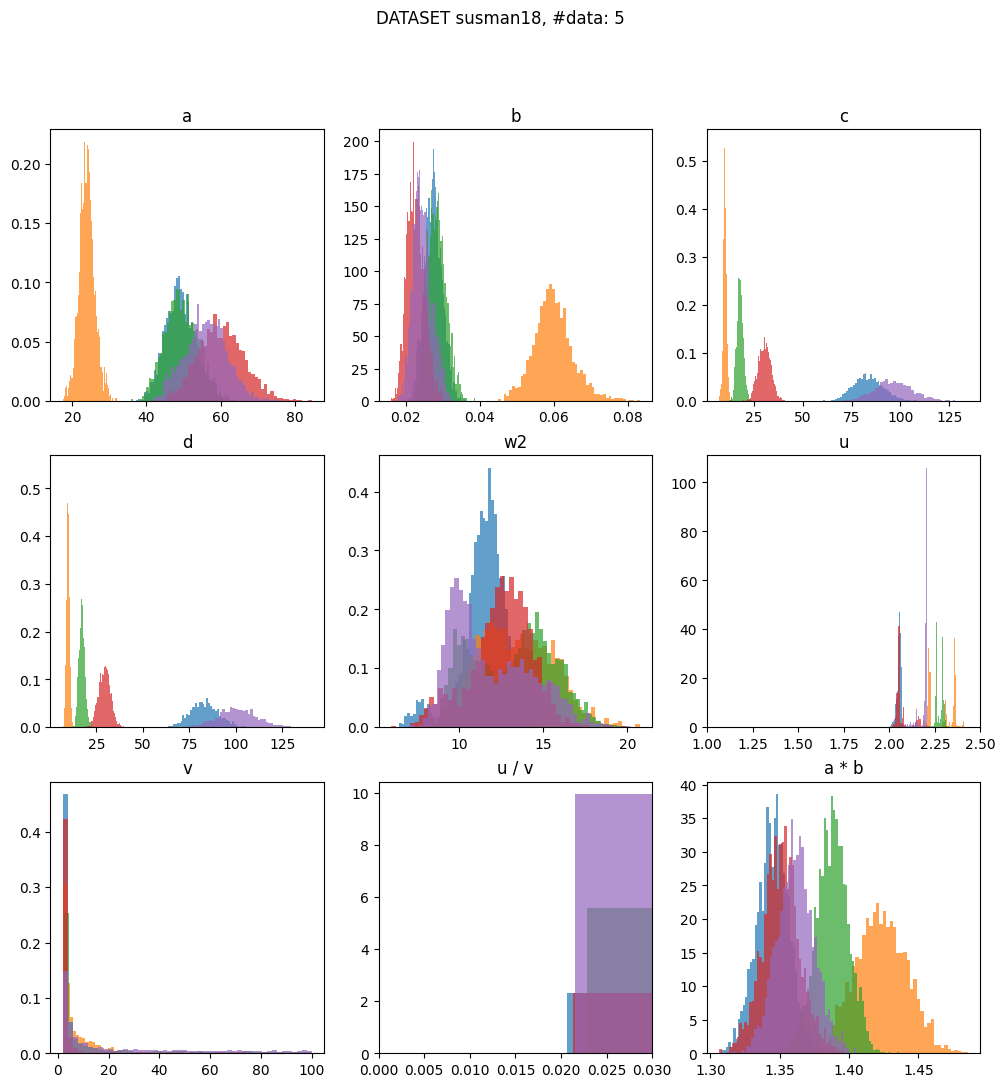

In [10]:
########### READ BACK THE FILE CREATED ########################
FOLDER_PATH = "./results/"
lineages = []

dataset_results_dict = read_files(FOLDER_PATH, df_name="sus", run_id=734846,lineages=lineages)

# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# for _, data in dataset_results_dict.items():
#     df_name, lin_id = data["dataset"], data["lineage_id"]
#     labels, samples, flat_samples = data["labels"], data["samples"], data["flat_samples"]
#     result_dict, truths = data["result_dict"], data["truths"]

#     title = f"DATASET {df_name}, lineage {lin_id}"

#     print(title)
#     plot_chains(samples, title=title, labels=labels)
#     fig = corner.corner(flat_samples, labels=labels, truths=truths)
#     fig.suptitle(title)
#     plt.show()
#     print_latex_result(list(result_dict.values()), labels)
#     print("-------------------------------")

# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
ROWS, COLS = 3, 3
fig, axs = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 4))

for i, data in enumerate(dataset_results_dict.values()):
    df_name, lin_id = data["dataset"], data["lineage_id"]
    labels, flat_samples = data["labels"], data["flat_samples"]
    result_dict, truths = data["result_dict"], data["truths"]

    # title = f"DATASET {df_name}, lineage {lin_id}"

    for j in range(flat_samples.shape[1]):
        nbins = int(np.sqrt(flat_samples[:, j].shape[0]))
        index = (j // COLS, j % COLS)
        axs[index].hist(flat_samples[:, j], alpha=0.7, bins=nbins, label=f"Lin {lin_id}", density=True)

    nbins = int(np.sqrt(flat_samples[:, j].shape[0]))
    
    axs[2, 2].hist(flat_samples[:, 0] * flat_samples[:, 1], label=f"Lin {lin_id}", alpha=0.7,
                bins=nbins, density=True)
    
    # if np.max(flat_samples[:, 6]) < 5000:
    #     print(lin_id)
    axs[2, 1].hist(flat_samples[:, 5] / flat_samples[:, 6], label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins, density=True)

for j, label in enumerate(labels):
    nbins = int(np.sqrt(flat_samples[:, j].shape[0]))
    index = (j // COLS, j % COLS)
    axs[index].set_title(label)
    # axs[index].legend()
# axs[2, 2].legend()
fig.suptitle(f"DATASET {df_name}, #data: {len(dataset_results_dict)}")
axs[2, 2].set_title("a * b")
axs[2, 1].set_title("u / v")
axs[2, 1].set_xlim(0, 0.03);
axs[1, 2].set_xlim(1, 2.5);


# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# ROWS, COLS = 2, 2

# for i, (_, data) in enumerate(dataset_results_dict.items()):
#     df_name, lin_id = data["dataset"], data["lineage_id"]
#     if int(lin_id) not in [1, 3, 4, 5, 6, 7] or not df_name.startswith("susman18"):
#         continue

#     print("Compatible file: ", df_name, " lineage: ", lin_id)
#     labels, flat_samples = data["labels"], data["flat_samples"]
#     results, truths = data["result_dict"], data["truths"]
#     data_length = data["data_length"]
#     # spans = data["data"]["spans"]
#     # alphas = data["data"]["alphas"]
#     # kappas = data["data"]["kappas"]
#     # m_finals = data["data"]["m_finals"]

#     params = {"a":results["a"][0], "b":results["b"][0], "c":results["c"][0], "d":results["d"][0],
#               "m_f":1, "w2":results["w2"][0], "u":results["u"][0], "v":results["v"][0]}
#     # print(params)
#     model_test = Model3(**params)
#     params_txt = " ".join([f"{k}={v:.3g}" for k, v in model_test.params_dict.items()])

#     evolver_test = Evolver(model_test)
#     evolver_test.evolve(n_div=data_length)

#     fig, axs = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 4))
#     model_data = [evolver_test.spans, evolver_test.get_alphas(), evolver_test.get_kappas(), evolver_test.get_mfinals()]
#     for j, (name, value) in enumerate(data["data"].items()):
#         nbins = int(np.sqrt(len(model_data[j])))

#         index = (j // COLS, j % COLS)
#         axs[index].hist(model_data[j], label="Generated", density=True, alpha=0.7, bins=nbins)
#         axs[index].hist(value, label="Lineage", density=True, alpha=0.7, bins=nbins)
#         axs[index].set_title(name)
#         axs[index].legend()
    
#     fig.suptitle(f"{DF_NAME} lineage: {lin_id}, params: {params_txt}", wrap=True)


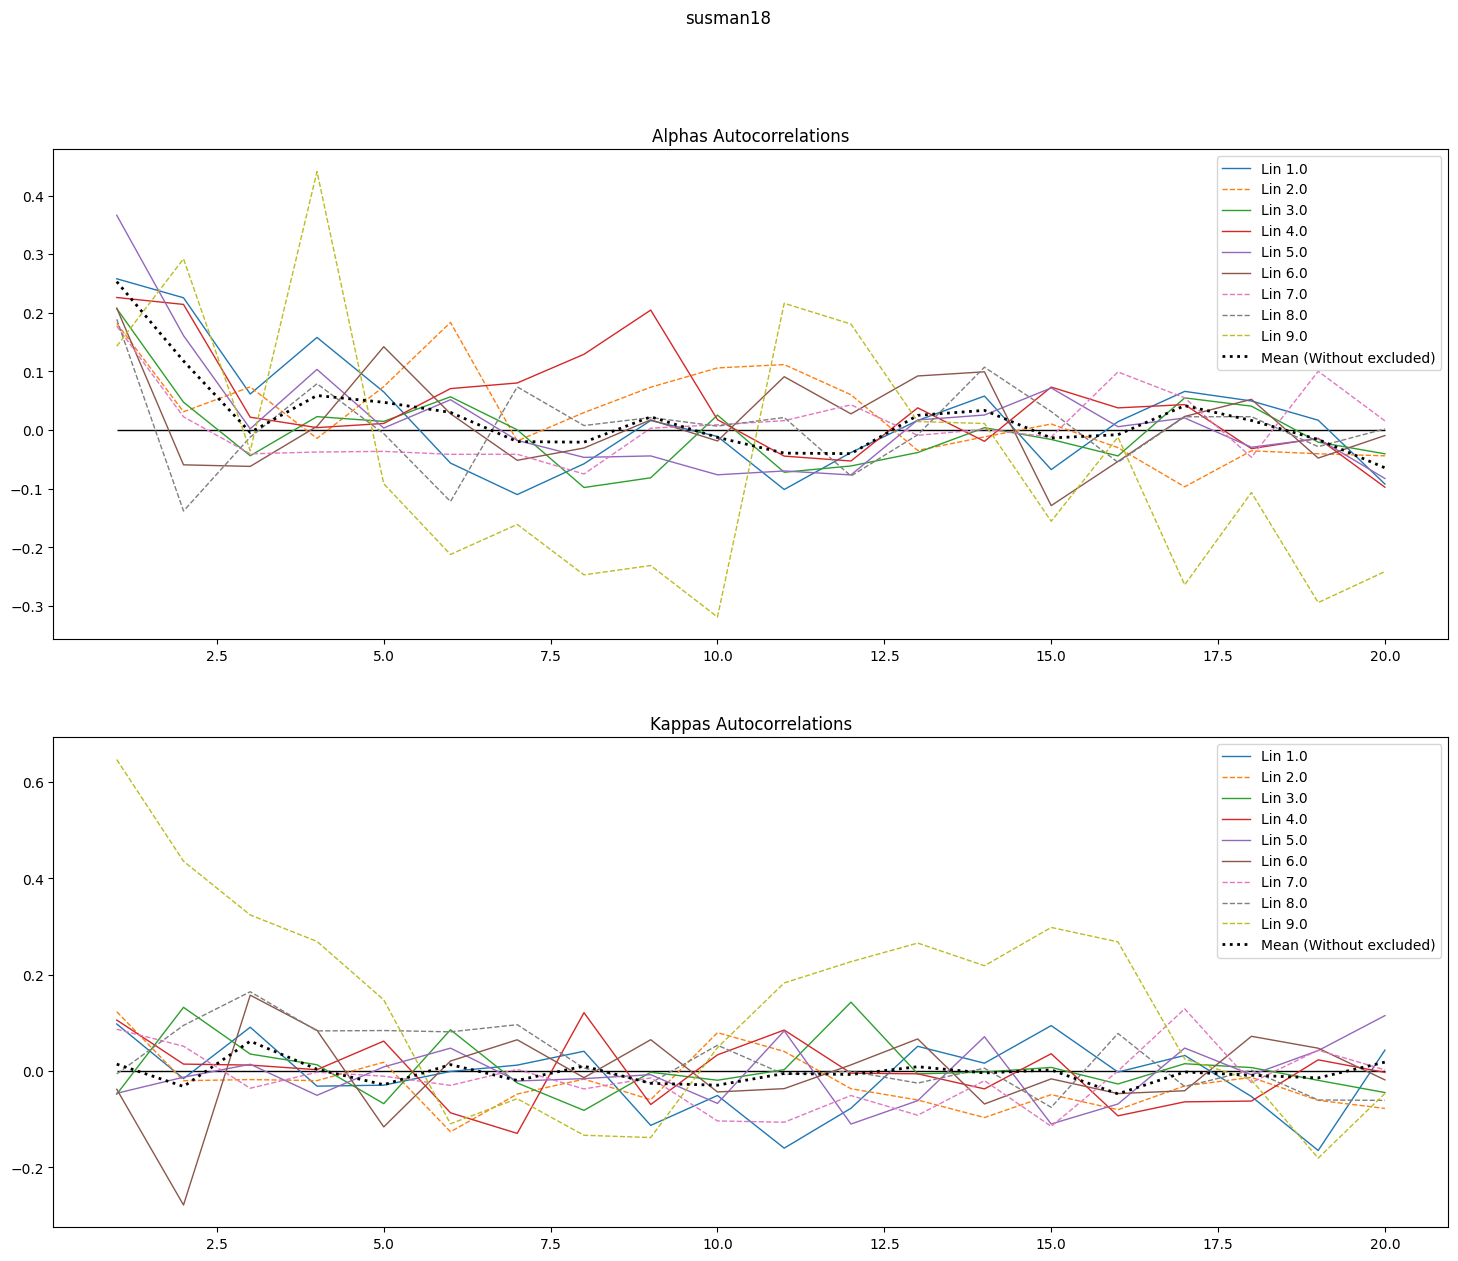

In [17]:
# df = tanouchi25c_set
# df = tanouchi37c_set
# df = susman18_set
df = susman18_set
run_id = "734846"


acmin = 1
acmax = 20 + 1
lineages = [*np.arange(1, 10)]
fig, axs = plt.subplots(2, 1, figsize=(18, 14))
# plt.acorr
plt.suptitle(f"{df.df_name}")
axs[0].hlines([0], acmin, acmax - 1, colors="black", lw=1)
axs[1].hlines([0], acmin, acmax - 1, colors="black", lw=1)
axs[0].set_title("Alphas Autocorrelations")
axs[1].set_title("Kappas Autocorrelations")

lineages_passed = [lin for _, _, lin in filter_file_names(FOLDER_PATH, df.df_name, run_id).values()]

sums = np.zeros(shape=(2, acmax - acmin))
n_data = 0
include_exc = False
for (lin_id,), df_lin in df.groupby(["lineage_ID"]):
    # print(f"DATASET {DF_NAME}, LINEAGE: {lin_id}, n data: {len(df_lin)}")
    if lineages and lin_id not in lineages:
        continue

    ac_alpha_list = []
    ac_kappa_list = []
    for i in range(acmin, acmax):
        a = df_lin["growth_rate"][:-i]
        b = df_lin["growth_rate"][i:]
        ac_alpha_list.append(np.corrcoef(a, b)[0, 1])

        c = df_lin["division_ratio"][1:][:-i]
        d = df_lin["division_ratio"][1:][i:]
        ac_kappa_list.append(np.corrcoef(c, d)[0, 1])

    passed = int(lin_id) in lineages_passed
    if include_exc or passed:
        sums[0, :] += ac_alpha_list
        sums[1, :] += ac_kappa_list
        n_data += 1

    x_range = np.arange(acmin, acmax)
    ls = "solid" if passed else "dashed"
    axs[0].plot(x_range, ac_alpha_list, label=f"Lin {lin_id}", ls=ls, lw=1)
    axs[1].plot(x_range, ac_kappa_list, label=f"Lin {lin_id}", ls=ls, lw=1)
    # plt.scatter(x_range, autocorre_list, s=10)

sums = sums/n_data
text_mean = "With excluded" if include_exc else "Without excluded"
axs[0].plot(x_range, sums[0, :], ls="dotted", color="black", lw=2, label=f"Mean ({text_mean})")
axs[1].plot(x_range, sums[1, :], ls="dotted", color="black", lw=2, label=f"Mean ({text_mean})")
axs[0].legend()
axs[1].legend();
